In [1]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt  

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date']) 
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)
df.head(2)

c:\Users\vlad\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills
0,Senior Data Engineer,Senior Clinical Data Engineer / Principal Clin...,"Watertown, CT",via Work Nearby,Full-time,False,"Texas, United States",2023-06-16 13:44:15,False,False,United States,None,NaN,NaN,Boehringer Ingelheim,None,None
1,Data Analyst,Data Analyst,"Guadalajara, Jalisco, Mexico",via BeBee México,Full-time,False,Mexico,2023-01-14 13:18:07,False,False,Mexico,None,NaN,NaN,Hewlett Packard Enterprise,"[r, python, sql, nosql, power bi, tableau]","{'analyst_tools': ['power bi', 'tableau'], 'pr..."


What are the most demanded skills for the top 3 most popular data roles?


<Axes: xlabel='quantity_of_skills', ylabel='job_skills'>

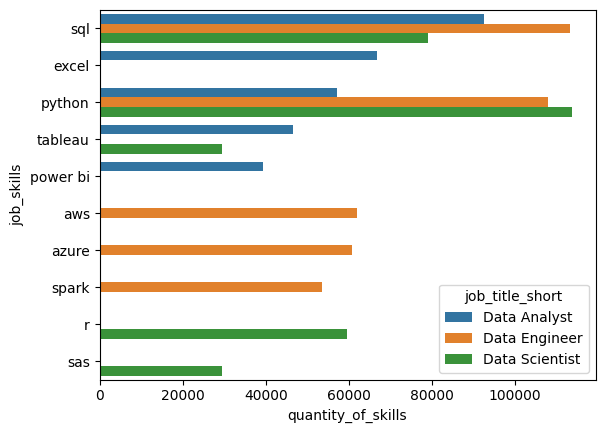

In [2]:
#variant 1
df2 = df.copy()
top_3_roles = df2['job_title_short'].value_counts().head(3).index.tolist() #list with 3 top roles
df_exploded = df2.explode(column='job_skills') #df with exploded skills
df_ready = df_exploded[df_exploded['job_title_short'].isin(top_3_roles)] # filtered by top toles
qwer = df_ready.groupby(by= ['job_title_short','job_skills']).agg(
    quantity_of_skills=pd.NamedAgg(column='job_skills', aggfunc='count')
    ).reset_index().sort_values('quantity_of_skills', ascending=False )
top_skills_all = (
    qwer
    .sort_values(['job_title_short', 'quantity_of_skills'], ascending=[True, False])
    .groupby('job_title_short')
    .head(5)
)
top_skills_all = top_skills_all.reset_index(drop=True)
top_skills_all
sns.barplot(
    data=top_skills_all,
    x='quantity_of_skills',
    y='job_skills',
    hue='job_title_short'
)

How are in-demand skills trending for Data Analysts?

C:\Users\vlad\AppData\Local\Temp\ipykernel_27348\3905504074.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


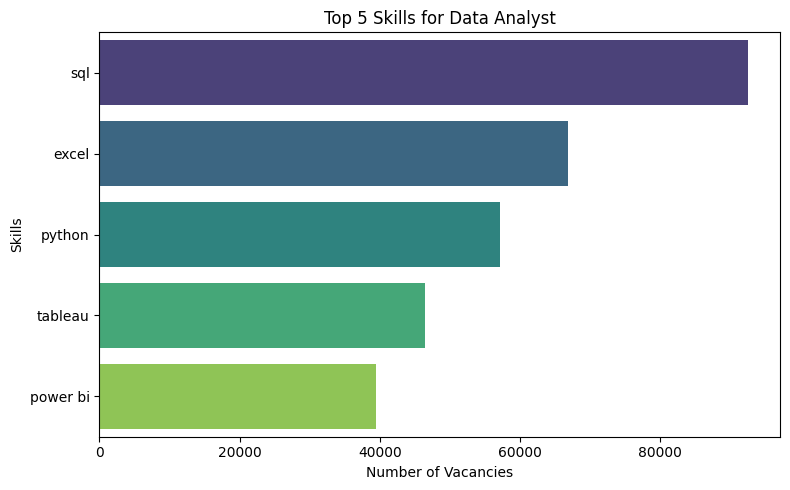

In [3]:
df3 = df.copy()
df_DA = df3[df3['job_title_short'] == 'Data Analyst'].explode(column='job_skills')
for_plot = (df_DA.groupby(['job_title_short', 'job_skills'])
.size()
.reset_index(name='count')
.sort_values('count', ascending=False)
.head(5)
)
plt.figure(figsize=(8,5))
sns.barplot(
    data=for_plot,
    y='job_skills',      
    x='count',           
    palette='viridis'    
)

plt.title('Top 5 Skills for Data Analyst')
plt.xlabel('Number of Vacancies')
plt.ylabel('Skills')
plt.tight_layout()
plt.show()

How well do jobs and skills pay for Data Analysts?

In [4]:
df4 = df.copy()

# filter the roles and explode the column with skills 
df_allda = df4[df4['job_title_short'].isin(['Data Analyst', 'Senior Data Analyst'])].explode(column='job_skills')

# delete nan value
df_allda = df_allda[df_allda['salary_year_avg'].notna()]

# the avg salary
pivot_jobs = df_allda.pivot_table(
    index='job_title_short', 
    values='salary_year_avg', 
    aggfunc='mean'
).round(0)

# the quantity of roles 
skills_count = (
    df_allda
    .groupby(['job_title_short', 'job_skills'])
    .size()
    .reset_index(name='count')
)

# top-5 skills for each role
top5_skills = (
    skills_count
    .sort_values(['job_title_short', 'count'], ascending=[True, False])
    .groupby('job_title_short')
    .head(5)
)

# create column and list we need
top_skills_list = top5_skills.groupby('job_title_short')['job_skills'].apply(list)

# addding columns
pivot_jobs['top_5_skills'] = top_skills_list

pivot_jobs


,salary_year_avg,top_5_skills
job_title_short,,
Data Analyst,96589.0,"[sql, excel, python, tableau, r]"
Senior Data Analyst,114351.0,"[sql, tableau, python, excel, r]"


What Job Opportunities are?

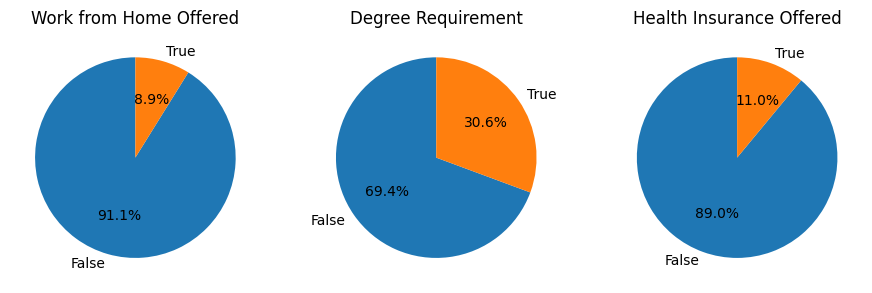

In [5]:


dict_column = {
    'job_work_from_home': 'Work from Home Offered',
    'job_no_degree_mention': 'Degree Requirement',
    'job_health_insurance': 'Health Insurance Offered'
}

fig, ax = plt.subplots(1, 3, figsize=(11, 3.5))

for i, (column, title) in enumerate(dict_column.items()):
    ax[i].pie(df[column].value_counts(), labels=['False', 'True'], autopct='%1.1f%%', startangle=90)
    ax[i].set_title(title)

plt.show()



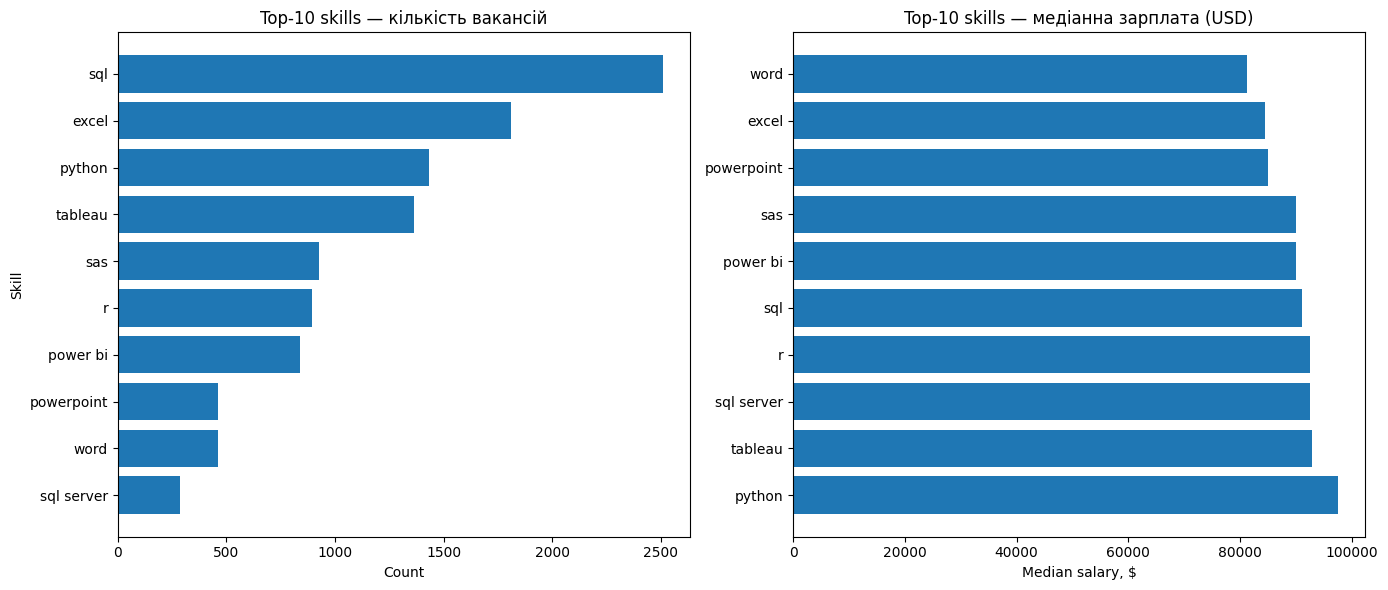

In [6]:



# Only get data analyst jobs in the US
df_DA_US = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'United States')].copy()

# Drop NaN values from the 'salary_year_avg' column for accurate visualization
df_DA_US = df_DA_US.dropna(subset=['salary_year_avg'])

df_DA_US = df_DA_US.explode('job_skills')
# Group by 'job_skills' and calculate count and median salary

df_DA_top_pay = df_DA_US.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='median', ascending=False)

df_DA_top_pay = df_DA_top_pay.head(10)

df_DA_top_pay

# calculate count

df_DA_skills = df_DA_US.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

df_DA_skills = df_DA_skills.head(10).sort_values(by='median', ascending=False)

df_DA_skills

# prepare data (separately sorted for better readability)
skills_by_count = df_DA_skills.sort_values('count', ascending=True)
skills_by_median = df_DA_skills.sort_values('median', ascending=True)

# create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1
axes[0].barh(skills_by_count.index, skills_by_count['count'])
axes[0].set_title('Top-10 skills — кількість вакансій')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Skill')


# 2
axes[1].barh(skills_by_median.index, skills_by_median['median'])
axes[1].set_title('Top-10 skills — медіанна зарплата (USD)')
axes[1].set_xlabel('Median salary, $')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()